<a href="https://colab.research.google.com/github/pumpzcc/EvolutionaryDeepLearning/blob/main/EDL_10_2_NEAT_XOR_Visualized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/CodeReclaimers/neat-python.git

  Cloning https://github.com/CodeReclaimers/neat-python.git to /tmp/pip-req-build-rjke3rac
  Running command git clone --filter=blob:none --quiet https://github.com/CodeReclaimers/neat-python.git /tmp/pip-req-build-rjke3rac
  Resolved https://github.com/CodeReclaimers/neat-python.git to commit 37bc8bb73fd6153a115001c2646f9f02bac3ad81
  Preparing metadata (setup.py) ... done
  Created wheel for neat-python: filename=neat_python-0.93-py3-none-any.whl size=43564 sha256=8ac899d40fdfb956d51369823f4a1102e0efa530d04e79dfd9d9c3ede7974278
  Stored in directory: /tmp/pip-ephem-wheel-cache-rca62c3z/wheels/23/a6/01/2c242e0ffec7801c7797caa13adc15a3361854465e28375261
Successfully built neat-python


In [2]:
import neat

In [3]:
# 2-input XOR inputs and expected outputs.
X = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
Y = [   (0.0,),     (1.0,),     (1.0,),     (0.0,)]

In [4]:
%%writefile config
#--- parameters for the XOR-2 experiment ---#

[NEAT]
fitness_criterion     = max
fitness_threshold     = 3.99
pop_size              = 150
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = sigmoid
activation_mutate_rate  = 0.0
activation_options      = sigmoid

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# genome compatibility options
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# connection add/remove rates
conn_add_prob           = 0.5
conn_delete_prob        = 0.5

# connection enable options
enabled_default         = True
enabled_mutate_rate     = 0.01

feed_forward            = True
initial_connection      = full

# node add/remove rates
node_add_prob           = 0.2
node_delete_prob        = 0.2

# network parameters
num_hidden              = 0
num_inputs              = 2
num_outputs             = 1

# node response options
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# connection weight options
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Writing config


In [5]:
# Load configuration.
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config')

print(config.genome_type, config.genome_config,config.pop_size)

<class 'neat.genome.DefaultGenome'> <neat.genome.DefaultGenomeConfig object at 0x7c92cdce5890> 150


In [6]:
key = "fred"
genome = config.genome_type(key)
genome.configure_new(config.genome_config)

net = neat.nn.FeedForwardNetwork.create(genome, config)

In [7]:
fitness = 4
for x, y in zip(X, Y):
  output = net.activate(x)
  print(output, y)
  fitness -= (output[0]-y[0])**2

print(fitness)

[0.00021466574202516422] (0.0,)
[1.951905766175073e-08] (1.0,)
[0.04612864556904923] (1.0,)
[4.396244746804456e-06] (0.0,)
2.090129432133471


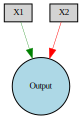

In [8]:
#@title Draw Network from Genome
import graphviz

def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        print("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)
    dot.view()

    return dot

node_names = {-1: 'X1', -2: 'X2', 0: 'Output'}
draw_net(config, genome, True, node_names=node_names)

In [9]:
def eval_genomes(genomes, config):
  for genome_id, genome in genomes:
    genome.fitness = 4.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    for x, y in zip(X, Y):
      output = net.activate(x)
      genome.fitness -= (output[0] - y[0]) ** 2


 ****** Running generation 0 ****** 

Population's average fitness: 2.23353 stdev: 0.37322
Best fitness: 2.99394 - size: (1, 2) - species 1 - id 17
Average adjusted fitness: 0.592
Mean genetic distance 1.321, standard deviation 0.887
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.025 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.35274 stdev: 0.31659
Best fitness: 2.99623 - size: (1, 2) - species 1 - id 245
Average adjusted fitness: 0.441
Mean genetic distance 1.834, standard deviation 1.077
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.019 sec (0.022 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.31965 stdev: 0.33818
Best fitness: 2.99886 - size: (1, 2) - species 1 - id 360
Average adjusted fitness: 0.390
Mean genetic distance 2.207, standard deviation 1.101
Population of 150 members in 2 species
Total extinctions: 0
Generation time: 0.014 sec (0.020 average)


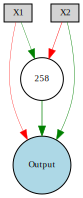

In [10]:
# Create the population, which is the top-level object for a NEAT run.
p = neat.Population(config)

# Add a stdout reporter to show progress in the terminal.
p.add_reporter(neat.StdOutReporter(False))

# Run until a solution is found.
winner = p.run(eval_genomes)

# Display the winning genome.
print('\nBest genome:\n{!s}'.format(winner))

# Show output of the most fit genome against training data.
print('\nOutput:')
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
for xi, xo in zip(X, Y):
  output = winner_net.activate(xi)
  print("  input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

draw_net(config, winner, True, node_names=node_names)

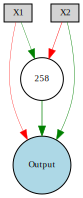

In [11]:
draw_net(config, winner, True, node_names=node_names)